#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Loading libraries and dataset

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
import re # Go to https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

C:\Users\Nihar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Nihar\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
con = sqlite3.connect('database.sqlite') #Here I am creating connection to my sqlite database, once I am connected I can fetch-
#- data from sqlite database by writing simple SQL command.

In [4]:
#Now I will filter out reviews with score = 3 and only consider reviews >3 and <3
filtered_data = pd.read_sql_query("""SELECT * 
FROM Reviews
WHERE Score!=3""",con)# Here I am running my SQL commands in brackets using 'con' connection.

In [5]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(filtered_data.shape)

(525814, 10)


In [7]:
#Here I am creating a function which will give reviews with score >3 a positive label, and reviews with a score <3 a negative-
#- label.
def partition(x):
    if x<3:
        return 'negative'
    return'positive'

In [8]:
actual_score = filtered_data['Score'] #Here we are storing the column 'Score' in variable 'actual_score'
positive_negative = actual_score.map(partition) #here we are applying partition function on each element in actual_score-
#- dataframe and then storing the resulting dataframe in positive _negative variable.

In [9]:
filtered_data['Score'] = positive_negative #putting positive_negative dataframe in 'Score' column of filtered_data.

In [10]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
filtered_data.shape

(525814, 10)

# 2. Exploratory Data Analysis

## 2.1 Data Cleaning

In [12]:
sorted_data = filtered_data.sort_values('Time', #Here we are sorting filtered_data according to Time in 
                                        axis = 0,    #- ascending order so that we can do time based splitting later.
                                        ascending = True,
                                        inplace = False, #inpace = false because we dont want to make modifications in-
                                        #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                        #- data in sorted_data
                                        kind = 'quicksort',
                                        na_position = 'last')
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [13]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#In above code we are saying that "consider the rows as duplicates if UserId, ProfileName, Time and Text are same, in such-
#- a case consider first row and drop rest of the duplicates. 'inplace = False' means 'dont change the original dataset.'"
final.shape

(364173, 10)

In [14]:
(final['Id'].count()/filtered_data['Id'].count())*100# here we are checking-
#- how much data is remaining out of 'filtered_data' in 'final' after removing duplicate rows

69.25890143662969

In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator] #Here we are only taking those rows for which-
#- HelpfulnessNumerator is less than or equal to HelpfulnessDenominator and dropping rest from 'final'

In [16]:
print(final.shape)
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [17]:
(final['Id'].count()/filtered_data['Id'].count())*100

69.25852107399194

In [18]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


## 2.2 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
#find explanation about re.compile(),re.sub() on analyticsvidhya tutorial
def cleanhtml(sentence): #function to clean word of any html tags
    cleanr = re.compile('<.*?>') #means find any text with angular braces
    cleantext = re.sub(cleanr,' ',sentence) # means replace the angular braces found in sentence with a empty space(' ').
    return cleantext
def cleanpunc(sentence):#function to clean the word of any punctuation or special character.
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence) # means replace special characters like ?,!,\'," and # with '' in sentence
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)# means replace special characters like .,,,),(,\ and / with ' '(space)-
    #- in cleaned and store the result in cleaned.
    return cleaned

In [20]:
stop = set(stopwords.words('english'))
# 'stopwords' module is imported from 'nltk.corpus' and 'words()' is a function in-
#- 'stopwords' module. Here we are trying to get set of all the stopwords in english language.
sno = nltk.stem.SnowballStemmer('english') #here we are initializing the snowball stemmer for english language.

In [21]:
#Here we will perform text-preprocessing steps.
i = 0
str1 = ' '
final_string = []
all_positive_words = [] #We will store words from positive reviews in this list
all_negative_words = [] #We will store words from negative reviews in this list
s = ''
for sent in final['Text'].values: #here we are looping each review in the list 'final['Text']''
    filtered_sentence = []
    sent = cleanhtml(sent) #Step1: In this step we will remove html tags from a review at each iteration of a for loop
    split_review = sent.split()#here I am splitting the review into words, words with punctuations etc..
    for w in split_review:#here I am looping each element in the list 'split_review'.
        cleaned_words_list_0 = cleanpunc(w)#Step2: here I am cleaning punctuations from each word 'w' using- 
        #- cleanpunc() function.
        cleaned_words_list = cleaned_words_list_0.split()# we have used cleanpunc(w).split(), one more split function here-
        #- because consider w="abc.def", cleanpunc(w) will return "abc def" if we dont use .split() function then we will-
        #- be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleaned_words_list:
            if((cleaned_words.isalpha())&(len(cleaned_words)>2)):#Step3: Here I am checking that if each of the cleaned_words is-
                #- alphanumeric or not and if the length of cleaned_words is greater than 2 or not-
                #- (as it was researched that there is no adjective in 2-letters)
                if (cleaned_words.lower() not in stop):#Step4: Here I am firstly converting a word to lower case and then-
                    #- checking if cleaned_word is a word in stopword, and if it is I am removing it.
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')#Step5: Here I am performing 
                    #- snowball stemming on'cleaned_words.lower()' and then encoding it to 'utf8'
                    filtered_sentence.append(s)#here I am storing all of the stemmed words in my review into-
                    #- a variable called 'filtered_sentence'. At each iteration of for loop-
                    #- (i.e. 'for w in split_review:' ) it stores a stemmed word of a word in the review whose-
                    #- html tags and punctuations are cleaned and which is neither a stopword nor a alphanumeric and has-
                    #- length > 2. At the end of one for loop 'for sent in final['Text'].values:' it has stored all the-
                    #- stemmed words in a review and then all the stemmed words in 'filtered_sentence' list are joined together-
                    #- and stored in 'str1' below. This 'str1' is then appended into 'final_string' list at the end of every-
                    #- for loop 'for sent in final['Text'].values:' and hence this 'final_string' list elements are-
                    #- reviews written in terms of stemmed words. At the start of next iteration of the same for loop i.e.-
                    #- 'for sent in final['Text'].values:' filtered_sentence is again initialized to empty list and str1-
                    #-again stores the stemmed words of next review joined together as a large string and is then again-
                    #- appended into final_string and so on.
                    if (final['Score'].values)[i]=='positive':#Here I am checking the score label(positive or negative)-
                        #-at the ith index in final['Score'].values list 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if (final['Score'].values)[i]=='negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)#Here we are joining all the stemmed words in 'filtered_sentence' list. 
    final_string.append(str1)
    i+=1

In [22]:
 #############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after-
#- pre-processing of the review.
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [23]:
#As we had initially encoded each of our word to utf-8 now we will decode them
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [24]:
# Below we are storing 'final' dataframe into an SQlLite table for future.    
conn = sqlite3.connect('final.sqlite') 
c=conn.cursor() #the .cursor() function is used to create a object like 'c' here so that we can use SQL commands
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
    
    
with open('positive_words.pkl', 'wb') as f:
    pickle.dump(all_positive_words, f)
with open('negitive_words.pkl', 'wb') as f:
    pickle.dump(all_negative_words, f)

In [25]:
final.to_csv('affrd_cleaned_preprocessed.csv')#here I am storing my cleaned dataset

In [26]:
#Doing time based splitting here and creating d_train, d_cv and d_test in ratio 60:20:20 (we have already sorted our dataset-
#- according to 'time' above using '.sort_values')
final_1 = final.iloc[0:100000]
d_train = final_1.iloc[0:60000]
d_cv = final_1.iloc[60000:80000]
d_test = final_1.iloc[80000:100001]

In [27]:
#storing d_train,d_cv and d_test into a .csv file
d_train.to_csv('affrd_train_100k.csv')
d_cv.to_csv('affrd_cv_100k.csv')
d_test.to_csv('affrd_test_100k.csv')

In [28]:
#storing my 'cleaned text' column in d_train into datapoint matrix x_train and 'Score' column in d_train into y_train-
#- and similar thing we are doing for d_cv and d_test
x_train = d_train['CleanedText']
y_train = d_train['Score']
x_cv = d_cv['CleanedText']
y_cv = d_cv['Score']
x_test = d_test['CleanedText']
y_test = d_test['Score']

# 3. Bag of words

In [29]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer() #defining our BOW model here
model = vectorizer.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'witti': 28468, 'littl': 14754, 'book': 2821, 'make': 15260, 'son': 23629, 'laugh': 14310, 'loud': 14948, 'recit': 20905, 'car': 3818, 'drive': 7645, 'along': 674, 'alway': 738, 'sing': 23119, 'refrain': 21054, 'hes': 11819, 'learn': 14401, 'whale': 28142, 'india': 12692, 'droop': 7661, 'love': 14961, 'new': 17157, 'word': 28559, 'introduc': 13039, 'silli': 23070, 'classic': 4893, 'will': 28356, 'bet': 2320, 'still': 24294, 'abl': 38, 'memori': 15859, 'colleg': 5173, 'rememb': 21204, 'see': 22524, 'show': 22951, 'air': 487, 'televis': 25412, 'year': 28791, 'ago': 439, 'child': 4528, 'sister': 23151, 'later': 14286, 'bought': 2904, 'day': 6435, 'thirti': 25696, 'someth': 23613, 'use': 27247, 'seri': 22655, 'song': 23631, 'student': 24483, 'teach': 25331, 'preschool': 19895, 'turn': 26506, 'whole': 28277, 'school': 22330, 'purchas': 20352, 'children': 4533, 'tradit': 26173, 'live': 14760, 'beetlejuic': 2133, 'well': 28075, 'written': 28656, 'movi': 16639, 'everyth': 8594, 'excel': 8650,

In [30]:
train_bow = model.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [31]:
#As our train_bow, cv_bow, test_bow matrices are already sparse csr matrices therefore we dont need to convert them-
#- to sparse matrices, we only need to store them now and we will store these sparse matrices as .npz files
ss.save_npz('train_bow.npz',train_bow)
ss.save_npz('cv_bow.npz',cv_bow)
ss.save_npz('test_bow.npz',test_bow)

In [33]:
#here we are first creating a dataframe out of train_bow and then doing column standardization on it
train_bow_df = pd.DataFrame(train_bow[0:3000,:].toarray(),columns = model.get_feature_names())
standardized_train = StandardScaler().fit_transform(train_bow_df)

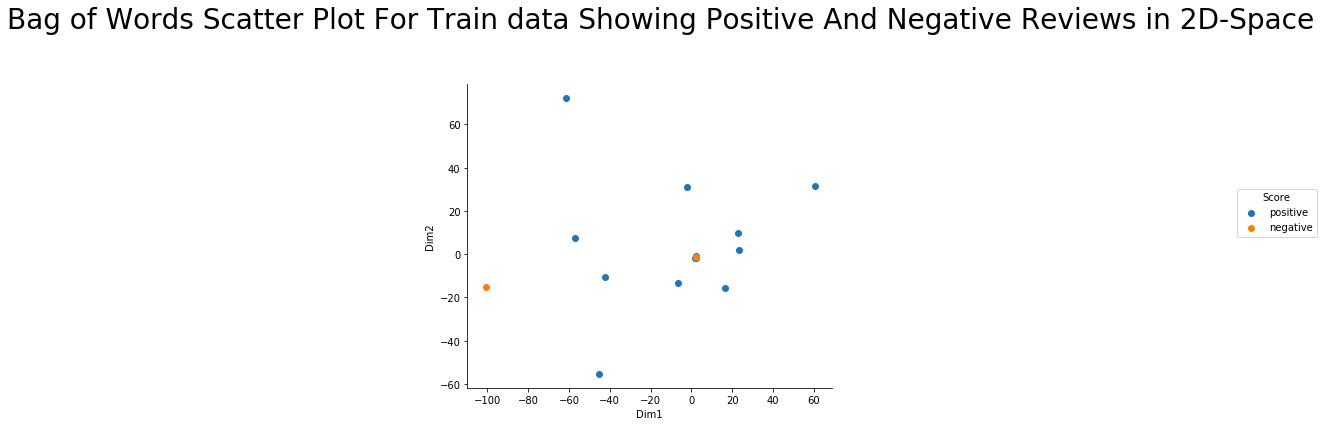

In [34]:
#Here we are creating a TSNE model such that we can convert our n-dimensional(n = 29128) standardized_train matrix into 2-D-
#- matrix for visualization
model_1 = TSNE(n_components = 2,random_state = 0)
Score = y_train[0:3000]
data_train = model_1.fit_transform(standardized_train)
tsne_data_train_df = pd.DataFrame(data_train,columns = ('Dim1','Dim2'))
tsne_data_train_df['Score'] = Score
sns.FacetGrid(tsne_data_train_df,hue = 'Score',size = 6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.subplots_adjust(top=0.8, wspace = 0.6)
plt.suptitle('Bag of Words Scatter Plot For Train data Showing Positive And Negative Reviews in 2D-Space',size = 28)
plt.show()

## Observation:
#### 1. Here in above plot we can see that for Dim1 > -80 we have all positive points and for Dim <-80 we have negative points. Thus we can separate positive points from negative points using a line Dim1 = -80 and hence we can create a simple if-else model to classify points as positive and negative.
#### 2. Also we can see a negative point in between set of positive points above at (0,0) which can most probably be an outlier.

## 3.1 TF-IDF

In [32]:
#tf-idf on train dataset
vectorizer_1 = TfidfVectorizer()#defining our tf-idf model
model = vectorizer_1.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer_1.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'witti': 28468, 'littl': 14754, 'book': 2821, 'make': 15260, 'son': 23629, 'laugh': 14310, 'loud': 14948, 'recit': 20905, 'car': 3818, 'drive': 7645, 'along': 674, 'alway': 738, 'sing': 23119, 'refrain': 21054, 'hes': 11819, 'learn': 14401, 'whale': 28142, 'india': 12692, 'droop': 7661, 'love': 14961, 'new': 17157, 'word': 28559, 'introduc': 13039, 'silli': 23070, 'classic': 4893, 'will': 28356, 'bet': 2320, 'still': 24294, 'abl': 38, 'memori': 15859, 'colleg': 5173, 'rememb': 21204, 'see': 22524, 'show': 22951, 'air': 487, 'televis': 25412, 'year': 28791, 'ago': 439, 'child': 4528, 'sister': 23151, 'later': 14286, 'bought': 2904, 'day': 6435, 'thirti': 25696, 'someth': 23613, 'use': 27247, 'seri': 22655, 'song': 23631, 'student': 24483, 'teach': 25331, 'preschool': 19895, 'turn': 26506, 'whole': 28277, 'school': 22330, 'purchas': 20352, 'children': 4533, 'tradit': 26173, 'live': 14760, 'beetlejuic': 2133, 'well': 28075, 'written': 28656, 'movi': 16639, 'everyth': 8594, 'excel': 8650,

In [33]:
train_tfidf = model.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model.transform(x_cv) #here we are using the internal parameters we learnt above to convert our reviews in x_cv into-
#- matrices
test_tfidf = model.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [34]:
#As our train_tfidf, cv_tfidf, test_tfidf matrices are already sparse csr matrices therefore we dont need to convert them-
#- to sparse matrices, we only need to store them now and we will store these sparse matrices as .npz files
ss.save_npz('train_tfidf.npz',train_tfidf)
ss.save_npz('cv_tfidf.npz',cv_tfidf)
ss.save_npz('test_tfidf.npz',test_tfidf)

In [35]:
#here we are first creating a dataframe out of train_tfidf and then doing column standardization on it
train_tfidf_df = pd.DataFrame(train_tfidf[0:3000,:].toarray(),columns = model.get_feature_names())
standardized_train = StandardScaler().fit_transform(train_tfidf_df)

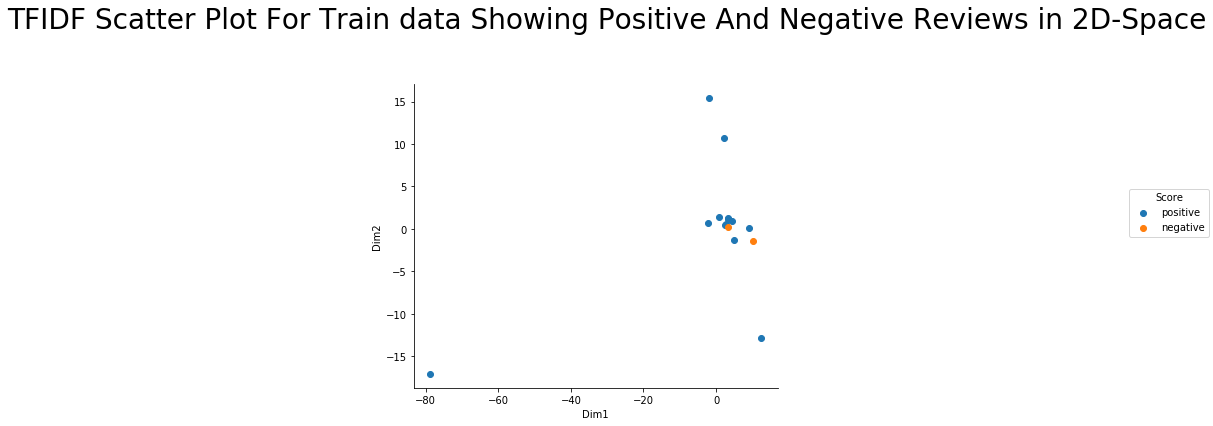

In [37]:
#Here we are creating a TSNE model such that we can convert our n-dimensional standardized_train matrix into 2-D-
#- matrix for visualization
model_1 = TSNE(n_components = 2,random_state = 0)
Score = y_train[0:3000]
data_train = model_1.fit_transform(standardized_train)
tsne_data_train_df = pd.DataFrame(data_train,columns = ('Dim1','Dim2'))
tsne_data_train_df['Score'] = Score
sns.FacetGrid(tsne_data_train_df,hue = 'Score',size = 6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.subplots_adjust(top=0.8, wspace = 0.6)
plt.suptitle('TFIDF Scatter Plot For Train data Showing Positive And Negative Reviews in 2D-Space',size = 28)
plt.show()

## Observation
#### 1. We can see that above points are linearly separable i.e. they can be separated with a straight line.
#### 2. We can see that the outliers exist for Dim1>80 or Dim2 > 80

# 4. Word2Vec

In [38]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [39]:
#splitting each of my reviews in x_cv into list of, list of stemmed words in each of our stemmed reviews in x_cv
list_of_sent_cv = []
for sent in x_cv.values:
    list_of_sent_cv.append(sent.split())

In [40]:
#splitting each of my reviews in x_test into list of, list of stemmed words in each of our stemmed reviews in x_test
list_of_sent_test = []
for sent in x_test.values:
    list_of_sent_test.append(sent.split())

In [41]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=9956, size=50, alpha=0.025)


['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'children', 'tradit', 'live', 'beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment', 'funni', 'hilari', 'wacki', 'great', 'help', 'think', 'one', 'best', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch', 'collect', 'fill', 'comedi', 'action', 'whatev', 'els', 'want',

## 4.1 Average Word2Vec

In [44]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:40<00:00, 214.11it/s]


60000
50


In [52]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:38<00:00, 202.79it/s]


20000
50


In [54]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:42<00:00, 194.30it/s]


20000
50


In [45]:
#here we are first creating a dataframe out of sent_vectors and then doing column standardization on it
tfidf_w2v_tr = pd.DataFrame(sent_vectors[0:3000])
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)

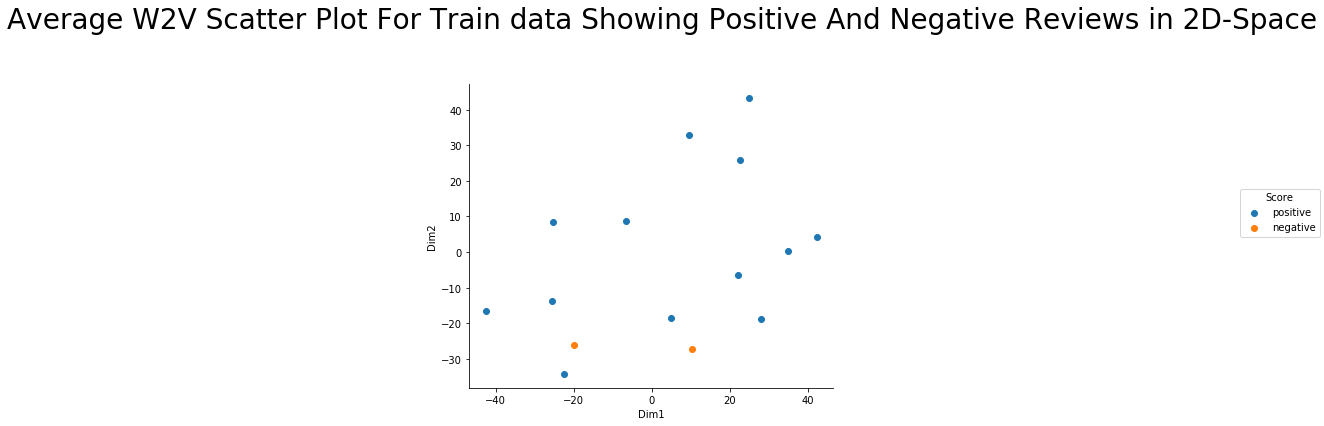

In [46]:
#Here we are creating a TSNE model such that we can convert our n-dimensional standardized_train matrix into 2-D-
#- matrix for visualization
model_3 = TSNE(n_components = 2,random_state = 0)
Score = y_train[0:3000]
data_train = model_3.fit_transform(standardized_train)
tsne_data_train_df = pd.DataFrame(data_train,columns = ('Dim1','Dim2'))
tsne_data_train_df['Score'] = Score
sns.FacetGrid(tsne_data_train_df,hue = 'Score',size = 6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.subplots_adjust(top=0.8, wspace = 0.6)
plt.suptitle('Average W2V Scatter Plot For Train data Showing Positive And Negative Reviews in 2D-Space',size = 28)
plt.show()

## Observation:
#### 1. We can see that we have positive points lying all over our 2-D space with some negative points in between.
#### 2. Here we can use technique like logistic regression  to separate positive points from negative points

## 4.2 Weighted Word2Vec

In [47]:
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [48]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [05:23<00:00, 185.47it/s]


60000
50


In [55]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:02<00:00, 163.42it/s]


20000
50


In [56]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:01<00:00, 134.66it/s]


20000
50


In [49]:
#here we are first creating a dataframe out of tfidf_sent_vectors_train and then doing column standardization on it
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train[0:3000])
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)

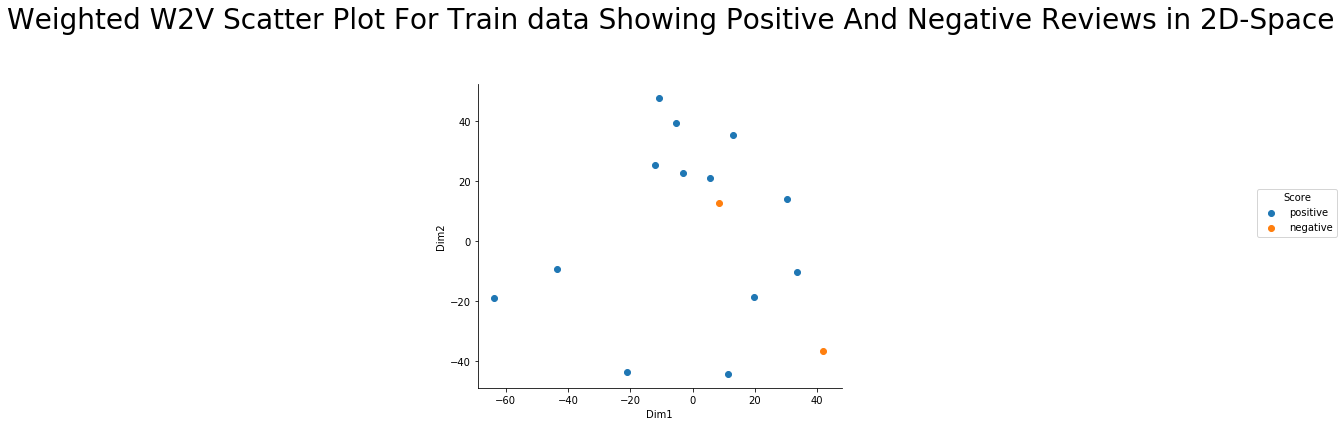

In [50]:
#Here we are creating a TSNE model such that we can convert our n-dimensional standardized_train matrix into 2-D-
#- matrix for visualization
model_3 = TSNE(n_components = 2,random_state = 0)
Score = y_train[0:3000]
data_train = model_3.fit_transform(standardized_train)
tsne_data_train_df = pd.DataFrame(data_train,columns = ('Dim1','Dim2'))
tsne_data_train_df['Score'] = Score
sns.FacetGrid(tsne_data_train_df,hue = 'Score',size = 6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.subplots_adjust(top=0.8, wspace = 0.6)
plt.suptitle('Weighted W2V Scatter Plot For Train data Showing Positive And Negative Reviews in 2D-Space',size = 28)
plt.show()

## Observation:
#### 1. Here we can see that our positive and negative datapoints are linearly separable and hence we can use logistic regression or decision trees to separate our positive and negative datapoints.

# Conclusion
<p>In this project we saw how to convert text into vectors using various techniques like Bag of words, TF-IDF, Average Word2Vec, and Weighted Word2Vec. We firstly did time based splitting on our dataset and divided it into train, CV and test in the ratio of 60:20:20. We saw that the vector representation we got for each review had large dimension and if we want to see how our positive and negative reviews where distributed in these high dimensional spaces we couldnt because we humans cant visualize high dimensional spaces. In order to concieve how our positive and negative reviews where distributed in high dimensional space we decreased the dimensionality of our vectors (which we got using various text to vector conversion techniques). Using TSNE we decreased the dimensionality of our vectors to 2 dimensions so that we can visualize the distribution of our positive and negative reviews. After we visualized how our positive and negative points are distributed we got to know that we can use various techniques like KNN, Naive Bayes and Logistic regression to classify if our query point is positive or negative. We can also see that average word2vec is performing brilliantly than bag of words, tfidf and weighted word2vec techniques on our training dataset x_train as it is separating the positive points from negative more accurately and hence we can use a simple model like logistic regression or decision tree to separate our positive points from negative points.
    The order in which the above techniques separate positive reviews from negative is:
    Average Word2Vec > Weighted Word2Vec > Bag of Words > TF-IDF
</p>